In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import griddata
import copy


# Set device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [63]:
 #Set seeds for reproducibility
def set_seed(seed=42):
    """
    Set seeds for reproducibility across Python, NumPy and PyTorch
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed} for reproducibility")

## Data generation

In [61]:
set_seed(0)
########################################################
# 1. Data Generation Functions
########################################################
def generate_test_data(n_side=200, device=device):
    # Construct an n_side x n_side uniform grid over the domain D = (0,1)^2
    x = np.linspace(0, 1, n_side)
    y = np.linspace(0, 1, n_side)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    X_test = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    # Exact solution: u(x,y)=30*x*(1-x)*y*(1-y)
    u_test = 30 * xx * (1 - xx) * yy * (1 - yy)
    return (torch.tensor(X_test, dtype=torch.float32).to(device),
            torch.tensor(u_test, dtype=torch.float32).to(device))

def generate_data_points_cartesian(n_side=15, device=device):
    """
    Construct a Cartesian grid over the observation subdomain D' = [0.125,0.875]^2
    with n_side x n_side points.
    """
    x = np.linspace(0.125, 0.875, n_side)
    y = np.linspace(0.125, 0.875, n_side)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    X_d = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    return torch.tensor(X_d, dtype=torch.float32).to(device)

def generate_collocation_points_sobol(num_points=175, device=device):
    """
    Use a Sobol sequence to sample num_points collocation points over the domain D = [0,1]^2 (for PDE residual).
    """
    sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
    X_int = sobol.draw(num_points).cpu().numpy()
    return torch.tensor(X_int, dtype=torch.float32, requires_grad=True).to(device)

def add_noise_to_data(data_pts, noise_noisy=1.0, noise_clean=0.01, noise_ratio=5/9):
    """
    Add noise to the exact labels corresponding to data_pts:
      - Compute clean labels using exact_solution(data_pts)
      - Randomly select a fraction (noise_ratio) of the data and add Gaussian noise (std=noise_std) to their labels; the rest remain clean.
    Returns the noisy labels u_data.
    """
    u_clean = exact_solution(data_pts)
    N = data_pts.shape[0]
    indices = torch.randperm(N)
    noisy_N = int(noise_ratio * N)
    noisy_indices = indices[:noisy_N]
    u_noisy = u_clean.clone()
    noise = noise_noisy * torch.randn(u_noisy[noisy_indices].shape, device=u_noisy.device)
    u_noisy[noisy_indices] = u_noisy[noisy_indices] + noise
    u_noisy[1-noisy_indices] = u_noisy[1-noisy_indices] + noise_clean * torch.randn(u_noisy[noisy_indices].shape, device=u_noisy.device)
    return u_noisy

########################################################
# 2. Exact Solution and Source Term
########################################################
def exact_solution(x):
    """
    Exact solution: u(x,y)=30*x*(1-x)*y*(1-y)
    Input x: Tensor of shape (N,2); returns a tensor of shape (N,1).
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    u = 30 * x1 * (1 - x1) * x2 * (1 - x2)
    return u.unsqueeze(1)

def source_term(x):
    """
    Source term: f(x)=60*(x1*(1-x1)+x2*(1-x2))
    Corresponds to the PDE: Δu + f = 0.
    Input x: Tensor of shape (N,2); returns a tensor of shape (N,1).
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    f = 60 * (x1 * (1 - x1) + x2 * (1 - x2))
    return f.unsqueeze(1)



In [62]:
# Generate test data
X_test, u_test = generate_test_data(n_side=200, device=device)

# Generate training data
data_pts = generate_data_points_cartesian(n_side=15, device=device)
# Add noise to the observed labels: add 0.5 Gaussian noise to 1/5 of the data, others 0.01 Gaussian
u_data = add_noise_to_data(data_pts, noise_noisy=0.5, noise_clean=0.01, noise_ratio=1/5)
collocation_pts = generate_collocation_points_sobol(num_points=175, device=device)

## train the baseline pinn model

In [41]:
########################################################
# 3. Model Definition: PoissonPINN
########################################################
class PoissonPINN(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=100, hidden_layers=5, out_dim=1):
        super(PoissonPINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
    
    def get_activation(self, x, layer_index):
        activation = None
        def hook(module, input, output):
            nonlocal activation
            activation = output
        handle = self.net[layer_index].register_forward_hook(hook)
        _ = self.net(x)
        handle.remove()
        return activation

########################################################
# 4. Compute Laplacian
########################################################
def compute_laplacian(u, x):
    """
    Compute the Laplacian of u with respect to x.
    u: Tensor of shape (N,1) (output)
    x: Tensor of shape (N,2) (input), with x.requires_grad=True.
    Returns: Tensor of shape (N,1)
    """
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grad_u_x = grad_u[:, 0:1]
    grad_u_y = grad_u[:, 1:2]
    grad_u_xx = torch.autograd.grad(grad_u_x, x, grad_outputs=torch.ones_like(grad_u_x), create_graph=True)[0][:, 0:1]
    grad_u_yy = torch.autograd.grad(grad_u_y, x, grad_outputs=torch.ones_like(grad_u_y), create_graph=True)[0][:, 1:2]
    return grad_u_xx + grad_u_yy

########################################################
# 5. Pretraining Stage: Pretrain using only data loss (Adam)
########################################################
def pretrain_data(model, data_pts, u_data, epochs, lr):
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))
    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(data_pts)
        loss = mse_loss(u_pred, u_data)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Pretrain Epoch {epoch}, Data Loss: {loss.item():.6f}")
    print("Pretraining (data loss only) completed.")
    return model

########################################################
# 6. Adaptive Weight Computation Function (using PDE and data loss)
########################################################
def compute_adaptive_weights(model, collocation_pts, data_pts, u_data, eps=1e-3, lambda_d_max=1e3):
    mse_loss = nn.MSELoss()
    # PDE loss
    u_coll = model(collocation_pts)
    lap_u = compute_laplacian(u_coll, collocation_pts)
    f = source_term(collocation_pts)
    loss_pde = mse_loss(lap_u + f, torch.zeros_like(f))
    grads_r = torch.autograd.grad(loss_pde, model.parameters(), retain_graph=True, allow_unused=True)
    trace_r = sum(torch.sum(g**2) if g is not None else 0.0 for g in grads_r)
    N_r = collocation_pts.shape[0]
    
    # Data loss
    u_data_pred = model(data_pts)
    loss_data = mse_loss(u_data_pred, u_data)
    grads_d = torch.autograd.grad(loss_data, model.parameters(), retain_graph=True, allow_unused=True)
    trace_d = sum(torch.sum(g**2) if g is not None else 0.0 for g in grads_d)
    N_d = data_pts.shape[0]
    
    R = (trace_r / N_r) + (trace_d / N_d)
    lambda_r = (N_r * R) / (trace_r + eps)
    lambda_d = (N_d * R) / (trace_d + eps)
    
    # Clip lambda_d to prevent it from being too large
    if lambda_d > lambda_d_max:
        lambda_d = torch.tensor(lambda_d_max, device=lambda_d.device) if isinstance(lambda_d, torch.Tensor) else lambda_d_max
    
    print(f"Adaptive weights computed: lambda_r={lambda_r.item():.6e}, lambda_d={lambda_d if isinstance(lambda_d, float) else lambda_d.item():.6e}")
    return lambda_r, lambda_d

########################################################
# 7. Second Stage: Fine-tune using Composite Loss (data + PDE) with L-BFGS
########################################################
def fine_tune_composite_lbfgs(model, collocation_pts, data_pts, u_data, lambda_r, lambda_d, max_iter):
    mse_loss = nn.MSELoss()
    optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=max_iter, history_size=50,
                                  tolerance_grad=1e-9, tolerance_change=1e-9, line_search_fn="strong_wolfe")
    
    def closure():
        optimizer_lbfgs.zero_grad()
        u_coll = model(collocation_pts)
        lap_u = compute_laplacian(u_coll, collocation_pts)
        f = source_term(collocation_pts)
        loss_pde = mse_loss(lap_u + f, torch.zeros_like(f))
        u_data_pred = model(data_pts)
        loss_data = mse_loss(u_data_pred, u_data)
        loss = lambda_r * loss_pde + lambda_d * loss_data
        loss.backward()
        return loss
    
    optimizer_lbfgs.step(closure)
    print("Composite fine-tuning with L-BFGS completed.")
    return model

In [42]:
def evaluate_model(model, N_test, device):
    x_test = np.random.rand(N_test, 2)
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    u_pred = model(x_test).detach()
    u_exact = exact_solution(x_test)
    error = torch.norm(u_pred - u_exact, 2) / torch.norm(u_exact, 2)
    print("Relative L2 error on test set: {:.6f}".format(error.item()))
    return x_test, u_pred, u_exact, error

def plot_solution(model, resolution, device):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    XY = np.column_stack([X.flatten(), Y.flatten()])
    XY_tensor = torch.tensor(XY, dtype=torch.float32).to(device)
    with torch.no_grad():
        u_pred = model(XY_tensor).cpu().numpy().reshape(resolution, resolution)
    u_exact = exact_solution(XY_tensor.cpu()).cpu().numpy().reshape(resolution, resolution)
    error = np.abs(u_pred - u_exact)
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    im0 = ax[0].contourf(X, Y, u_exact, 50, cmap='viridis')
    ax[0].set_title("Exact Solution")
    fig.colorbar(im0, ax=ax[0])
    im1 = ax[1].contourf(X, Y, u_pred, 50, cmap='viridis')
    ax[1].set_title("Predicted Solution")
    fig.colorbar(im1, ax=ax[1])
    im2 = ax[2].contourf(X, Y, error, 50, cmap='viridis')
    ax[2].set_title("Absolute Error")
    fig.colorbar(im2, ax=ax[2])
    plt.tight_layout()
    plt.show()

Initial Model:
PoissonPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Tanh()
    (10): Linear(in_features=100, out_features=1, bias=True)
  )
)
Start pretraining (data loss only) ...
Pretrain Epoch 0, Data Loss: 1.387608
Pretrain Epoch 500, Data Loss: 0.046549
Pretrain Epoch 1000, Data Loss: 0.045447
Pretrain Epoch 1500, Data Loss: 0.044446
Pretrain Epoch 2000, Data Loss: 0.041473
Pretrain Epoch 2500, Data Loss: 0.032749
Pretrain Epoch 3000, Data Loss: 0.023576
Pretrain Epoch 3500, Data Loss: 0.012333
Pretrain Epoch 4000, Data Loss: 0.008033
Pretrain Epoch 4500, Data Loss: 0.008459
Pretrain Epoch 5000, Data Loss: 0.004508
Pretrain E

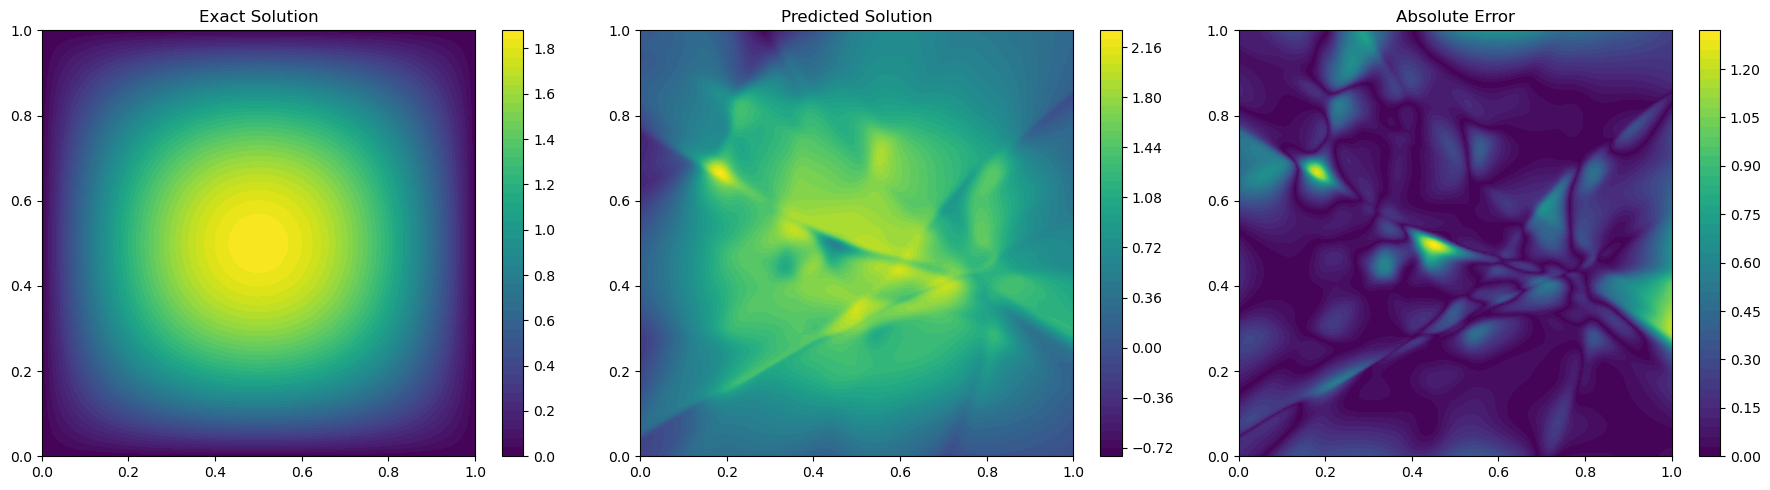

In [43]:
set_seed(0)
# Build the PINN model
model = PoissonPINN(in_dim=2, hidden_dim=100, hidden_layers=5, out_dim=1).to(device)
print("Initial Model:")
print(model)

# Pretraining Stage: Pretrain using only data loss (Adam)
pretrain_epochs = 20000  # M1
lr_pretrain = 1e-3
print("Start pretraining (data loss only) ...")
pretrain_data(model, data_pts, u_data, pretrain_epochs, lr_pretrain)

# Compute adaptive weights
lambda_r, lambda_d = compute_adaptive_weights(model, collocation_pts, data_pts, u_data)

# Second Stage: Fine-tune using composite loss (PDE + Data) with L-BFGS, iterate M2 times
M2 = 5000
print("Start composite fine-tuning with L-BFGS ...")
fine_tune_composite_lbfgs(model, collocation_pts, data_pts, u_data, lambda_r, lambda_d, max_iter=M2)

# Evaluate the model after pre-fine-tuning
evaluate_model(model, N_test=10000, device=device)
plot_solution(model, resolution=200, device=device)

## Data partition and selective-pruning

In [44]:

def partition_data_by_u(model, X_data, u_data, eps=0.01, w_data=1.0, w_res=0.001):
    """
    Partition the labeled data based on a composite error defined as:
      composite_error = w_data * ((u_pred - u_true)^2) + w_res * ((Δu + f)^2)
    where Δu is computed using the compute_laplacian function and f(x) is the source term.
    Samples with composite error below eps are considered "good" (retained).
    
    Parameters:
      model: Trained PINN model.
      X_data: Input data with shape [N, 2] (x and t) (requires_grad should be False).
      u_data: True solution with shape [N, 1].
      eps: Fixed threshold for composite error.
      w_data: Weight for the data loss error.
      w_res: Weight for the PDE residual error.
    
    Returns:
      A tuple ((X_good, u_good), (X_bad, u_bad)) for retained and discarded samples.
    """
    model.eval()
    with torch.no_grad():
        u_pred = model(X_data)
    data_err = (u_pred - u_data)**2
    # Compute PDE residual: Δu + f(x)
    X_data_grad = X_data.clone().detach().requires_grad_(True)
    u_for_res = model(X_data_grad)
    lap_u = compute_laplacian(u_for_res, X_data_grad)
    f_val = source_term(X_data_grad)
    res = lap_u + f_val
    res_err = res**2
    composite_err = (w_data * data_err + w_res * res_err).squeeze().cpu().detach().numpy()
    good_idx = np.where(composite_err < eps)[0]
    bad_idx = np.where(composite_err >= eps)[0]
    print(f"Composite error threshold (eps): {eps:.6e}, Good samples: {len(good_idx)}, Bad samples: {len(bad_idx)}")
    X_good = X_data[good_idx]
    u_good = u_data[good_idx]
    X_bad = X_data[bad_idx]
    u_bad = u_data[bad_idx]
    return (X_good, u_good), (X_bad, u_bad)

def fine_tune_poisson(model, collocation_pts, data_pts, u_data, adam_epochs=2000, adam_lr=1e-3, lbfgs_epochs=500, 
                        lambda_p=0.001, lambda_d=1.0):
        """
        Fine-tune the model:
          Phase 1: Train for adam_epochs with Adam on the composite loss (data + PDE loss)
          Phase 2: Further fine-tune for lbfgs_epochs using L-BFGS on the same composite loss.
        The composite loss is defined as:
            L = lambda_p * L_pde + lambda_d * L_data,
        where:
            L_pde = MSE(Δu + f, 0)
            L_data = MSE(u_pred, u_data)
        """
        mse_loss = nn.MSELoss()
        
        # Phase 1: Adam optimization
        optimizer_adam = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=1e-5)
        print("Phase 1 fine-tuning with Adam ...")
        for epoch in range(adam_epochs):
            optimizer_adam.zero_grad()
            # Compute PDE residual loss
            u_coll = model(collocation_pts)
            lap_u = compute_laplacian(u_coll, collocation_pts)
            f = source_term(collocation_pts)
            loss_pde = mse_loss(lap_u + f, torch.zeros_like(f))
            # Compute data loss
            u_data_pred = model(data_pts)
            loss_data = mse_loss(u_data_pred, u_data)
            loss = lambda_p * loss_pde + lambda_d * loss_data
            loss.backward()
            optimizer_adam.step()
            if epoch % 200 == 0:
                print(f"Adam Epoch {epoch}: Total Loss = {loss.item():.6f}, PDE Loss = {loss_pde.item():.6f}, Data Loss = {loss_data.item():.6f}")
        print("Phase 1 fine-tuning with Adam completed.")
        
        # Phase 2: L-BFGS optimization
        optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, history_size=50,
                                       tolerance_grad=1e-9, tolerance_change=1e-9, line_search_fn="strong_wolfe")
        
        def closure():
            optimizer_lbfgs.zero_grad()
            u_coll = model(collocation_pts)
            lap_u = compute_laplacian(u_coll, collocation_pts)
            f = source_term(collocation_pts)
            loss_pde = mse_loss(lap_u + f, torch.zeros_like(f))
            u_data_pred = model(data_pts)
            loss_data = mse_loss(u_data_pred, u_data)
            loss = lambda_p * loss_pde + lambda_d * loss_data
            loss.backward()
            return loss
        
        print("Phase 2 fine-tuning with L-BFGS ...")
        optimizer_lbfgs.step(closure)
        print("Phase 2 fine-tuning with L-BFGS completed.")
        
        return model


In [45]:
#eps, w_data, w_res are hyperparameters

(X_good, u_good), (X_bad, u_bad)  = partition_data_by_u(model, data_pts, u_data, eps=1, w_data=0.01, w_res=0.00001)


Composite error threshold (eps): 1.000000e+00, Good samples: 160, Bad samples: 65


In [46]:
# . Others: Selective Pruning, 
########################################################
def prune_neuron(model, layer_index, neuron_idx):
    linear_layer = model.net[layer_index]
    next_layer = None
    for i in range(layer_index + 1, len(model.net)):
        if isinstance(model.net[i], nn.Linear):
            next_layer = model.net[i]
            break
    if next_layer is None:
        print("No subsequent linear layer found, skipping pruning")
        return
    with torch.no_grad():
        linear_layer.weight[neuron_idx, :] = 0.0
        if linear_layer.bias is not None:
            linear_layer.bias[neuron_idx] = 0.0
        next_layer.weight[:, neuron_idx] = 0.0

def selective_pruning_layer(model, layer_index, retain_data, forget_data, alpha=0.01, num_iter=3):
    X_good = retain_data[0]
    X_bad = forget_data[0]
    for it in range(num_iter):
        acts_good = model.get_activation(X_good, layer_index).detach().cpu().numpy()
        acts_bad = model.get_activation(X_bad, layer_index).detach().cpu().numpy()
        num_neurons = acts_good.shape[1]
        scores = np.zeros(num_neurons)
        for n in range(num_neurons):
            mg = np.mean(acts_good[:, n])
            mb = np.mean(acts_bad[:, n])
            scores[n] = mb - mg
        c = np.mean(np.abs(np.concatenate([acts_good, acts_bad], axis=0))) + 1e-8
        scores = scores / c
        k = int(alpha * num_neurons)
        prune_idx = np.argsort(scores)[-k:]
        print(f"Layer {layer_index}, Iteration {it}: Pruning neuron indices = {prune_idx}, scores = {scores[prune_idx]}")
        for idx in prune_idx:
            prune_neuron(model, layer_index, idx)
    return model

def selective_pruning_multi_layers(model, layer_indices, retain_data, forget_data, alpha=0.01, num_iter=3):
    for li in layer_indices:
        model = selective_pruning_layer(model, li, retain_data, forget_data, alpha, num_iter)
    return model

In [47]:
# Partition the labeled data based on composite error (data loss + PDE residual loss)
# using a fixed threshold (eps). Samples with composite error < eps are retained.

# Perform selective pruning on specified layers (e.g., layers [0,2,4,6])
model_pruned = copy.deepcopy(model)
layer_indices = [0, 2, 4, 6, 8]
# Selectively prune the first hidden layer
print("Start selective pruning on layer 0 ...")
model_pruned = selective_pruning_multi_layers(model_pruned, layer_indices=layer_indices,
                                         retain_data=(X_good, u_good),
                                         forget_data=(X_bad, u_bad),
                                         alpha=0.05, num_iter=10)

Start selective pruning on layer 0 ...
Layer 0, Iteration 0: Pruning neuron indices = [95 37 70 50 86], scores = [0.06854207 0.06956859 0.07045932 0.07228697 0.07869602]
Layer 0, Iteration 1: Pruning neuron indices = [13 89 67 32 71], scores = [0.05344403 0.05536751 0.05834217 0.05920835 0.0649034 ]
Layer 0, Iteration 2: Pruning neuron indices = [91 23 48 25 85], scores = [0.0524796  0.05272996 0.05316009 0.05397642 0.05409117]
Layer 0, Iteration 3: Pruning neuron indices = [78 27 46 19 73], scores = [0.04794486 0.05021758 0.05490407 0.05501405 0.05525797]
Layer 0, Iteration 4: Pruning neuron indices = [57 34 26 60 45], scores = [0.03861465 0.04412999 0.04500736 0.04881471 0.04918362]
Layer 0, Iteration 5: Pruning neuron indices = [10 30 92 41  8], scores = [0.0351074  0.03866889 0.03926931 0.04008116 0.0402941 ]
Layer 0, Iteration 6: Pruning neuron indices = [28 59  3 36 77], scores = [0.02383214 0.02480269 0.02599179 0.03264892 0.03678183]
Layer 0, Iteration 7: Pruning neuron indices

## finetune

Start fine-tuning pruned model ...
Phase 1 fine-tuning with Adam ...
Adam Epoch 0: Total Loss = 311.366943, PDE Loss = 6205.892578, Data Loss = 1.072283
Adam Epoch 200: Total Loss = 1.288114, PDE Loss = 21.404545, Data Loss = 0.217886
Adam Epoch 400: Total Loss = 0.266781, PDE Loss = 3.101887, Data Loss = 0.111686
Adam Epoch 600: Total Loss = 0.109405, PDE Loss = 0.940063, Data Loss = 0.062402
Adam Epoch 800: Total Loss = 0.060507, PDE Loss = 0.372103, Data Loss = 0.041902
Adam Epoch 1000: Total Loss = 0.042572, PDE Loss = 0.179203, Data Loss = 0.033611
Adam Epoch 1200: Total Loss = 0.034036, PDE Loss = 0.105864, Data Loss = 0.028743
Adam Epoch 1400: Total Loss = 0.028497, PDE Loss = 0.071262, Data Loss = 0.024934
Adam Epoch 1600: Total Loss = 0.024365, PDE Loss = 0.050664, Data Loss = 0.021832
Adam Epoch 1800: Total Loss = 0.021189, PDE Loss = 0.036297, Data Loss = 0.019374
Phase 1 fine-tuning with Adam completed.
Phase 2 fine-tuning with L-BFGS ...
Phase 2 fine-tuning with L-BFGS com

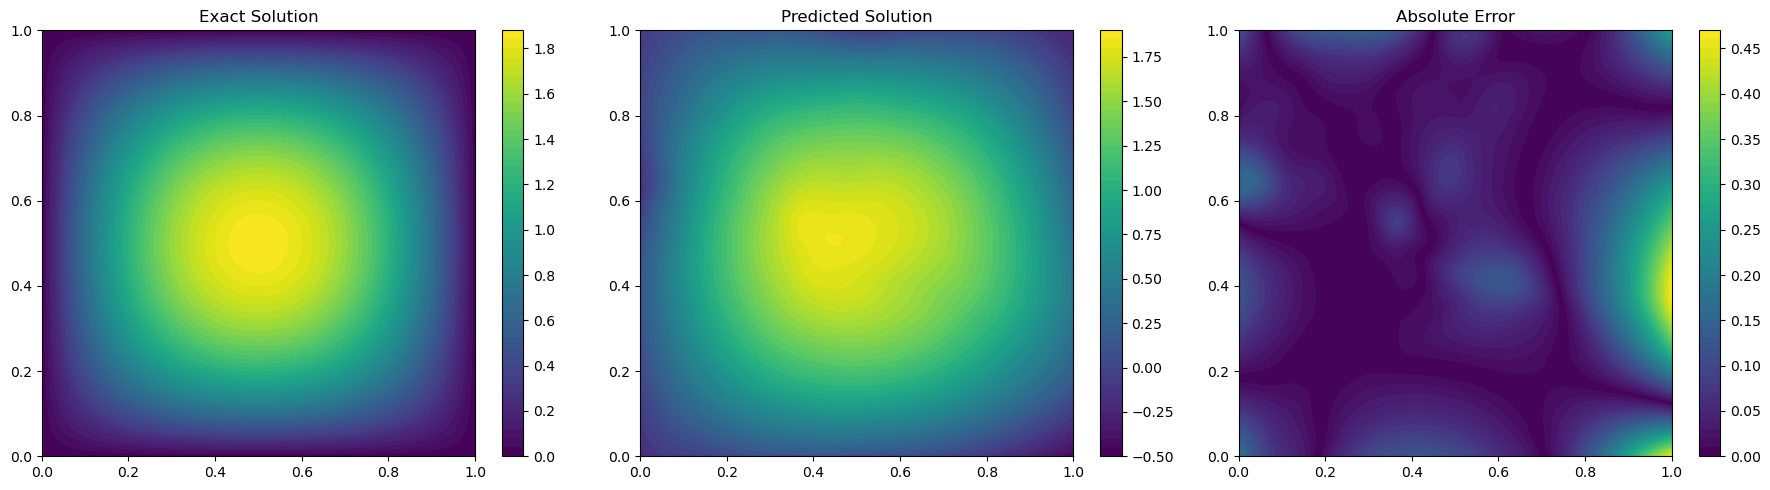

In [48]:

#specify lambda_p and lambda_d
# Fine-tune the pruned model using good samples (subsequent fine-tuning phase with Adam)
fine_tune_epochs = 2000
lr_finetune = 1e-3
print("Start fine-tuning pruned model ...")

model_pruned = fine_tune_poisson(model_pruned,  collocation_pts, X_good, u_good, 
                          adam_epochs=2000, adam_lr=1e-3, lbfgs_epochs=500,
                            lambda_p=0.05, lambda_d=1.0)

# Final evaluation and plotting
evaluate_model(model_pruned, N_test=10000, device=device)
plot_solution(model_pruned, resolution=200, device=device)

## comparison

In [49]:
def evaluate_metric(model, N_test, device):
    x_test = np.random.rand(N_test, 2)
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    u_pred = model(x_test).detach()
    u_exact = exact_solution(x_test)
    l2_re = torch.norm(u_pred - u_exact, 2) / torch.norm(u_exact, 2)
    l1_re = torch.sum(torch.abs(u_pred - u_exact)) / torch.sum(torch.abs(u_exact))
    mse = torch.mean((u_pred - u_exact)**2)
    max_err = torch.max(torch.abs(u_pred - u_exact))
    print("Relative L2 Error: {:.6f}".format(l2_re.item()))
    print("Relative L1 Error: {:.6f}".format(l1_re.item()))
    print("MSE: {:.6f}".format(mse.item()))
    print("Max Error: {:.6f}".format(max_err.item()))
    return l2_re.item(), l1_re.item(), mse.item(), max_err.item()


In [50]:
#baseline pinn
evaluate_metric(model, N_test=10000, device=device)

Relative L2 Error: 0.225142
Relative L1 Error: 0.176384
MSE: 0.050503
Max Error: 1.295906


(0.22514232993125916,
 0.1763840615749359,
 0.05050281062722206,
 1.295905590057373)

In [51]:
# pruned-pinn
evaluate_metric(model_pruned, N_test=10000, device=device)

Relative L2 Error: 0.089063
Relative L1 Error: 0.064950
MSE: 0.007835
Max Error: 0.460081


(0.08906296640634537,
 0.06494998186826706,
 0.007835322059690952,
 0.4600813686847687)

In [52]:
import numpy as np

def compute_frmse_bands_2d(u_field, freq_bands=[(0,4), (5,12), (13,1e9)]):
    """
    Compute the FRMSE in different frequency bands for a 2D field.
    
    Parameters:
    -----------
    u_field : 2D numpy array
        Field on a grid, shape (Nx, Ny).
    freq_bands : list of tuples
        Each tuple (k_min, k_max) defines a frequency band.
    
    Returns:
    --------
    frmses : list of floats
        FRMSE for each frequency band.
    """
    Nx, Ny = u_field.shape
    U_field = np.fft.fft2(u_field)
    U_field_shifted = np.fft.fftshift(U_field)
    
    # Build frequency index arrays
    freq_x = np.fft.fftfreq(Nx)
    freq_y = np.fft.fftfreq(Ny)
    freq_x = np.fft.fftshift(freq_x) * Nx
    freq_y = np.fft.fftshift(freq_y) * Ny
    fx_grid, fy_grid = np.meshgrid(freq_x, freq_y, indexing='ij')
    r = np.sqrt(fx_grid**2 + fy_grid**2)
    
    magnitude_sq = np.abs(U_field_shifted)**2
    frmses = []
    for (kmin, kmax) in freq_bands:
        mask = (r >= kmin) & (r <= kmax)
        count = np.sum(mask)
        if count > 0:
            band_error = np.sum(magnitude_sq[mask])
            frmse = np.sqrt(band_error / count)
        else:
            frmse = 0.0
        frmses.append(frmse)
    return frmses

def evaluate_frmse(u_field_pred, u_field_true):
    """
    Compute the FRMSE for a 2D field between predicted and true values.
    
    Returns a dictionary with keys 'low_frmse', 'mid_frmse', and 'high_frmse'.
    """
    bands = [(0,4), (5,12), (13,1e9)]
    error_2d = u_field_pred-u_field_true
    frmse_values = compute_frmse_bands_2d(error_2d, freq_bands=bands)
    return {
        "low_frmse": frmse_values[0],
        "mid_frmse": frmse_values[1],
        "high_frmse": frmse_values[2]
    }


In [53]:
Nx, Ny = 100, 100
x_lin = np.linspace(0, 1, Nx)
y_lin = np.linspace(0, 1, Ny)
xx, yy = np.meshgrid(x_lin, y_lin, indexing='ij')
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
grid_points = torch.tensor(grid_points, dtype=torch.float32).to(device)

In [54]:
# for baseline-pinn
u_pred = model(grid_points).detach()
u_exact = exact_solution(grid_points)

In [55]:
frmse_dict = evaluate_frmse(u_pred.cpu().detach().reshape(Nx, Ny), u_exact.cpu().detach().reshape(Nx, Ny))
print("Low-frequency FRMSE:", frmse_dict["low_frmse"])
print("Mid-frequency FRMSE:", frmse_dict["mid_frmse"])
print("High-frequency FRMSE:", frmse_dict["high_frmse"])

Low-frequency FRMSE: 213.5961605624971
Mid-frequency FRMSE: 71.96795537040398
High-frequency FRMSE: 6.318758078896499


In [56]:
#for pruned-pinn
u_pred = model_pruned(grid_points).detach()


In [57]:
frmse_dict = evaluate_frmse(u_pred.cpu().detach().reshape(Nx, Ny), u_exact.cpu().detach().reshape(Nx, Ny))
print("Low-frequency FRMSE:", frmse_dict["low_frmse"])
print("Mid-frequency FRMSE:", frmse_dict["mid_frmse"])
print("High-frequency FRMSE:", frmse_dict["high_frmse"])

Low-frequency FRMSE: 117.4331490883171
Mid-frequency FRMSE: 13.4269327979666
High-frequency FRMSE: 1.8016729212759244
